# Optimisation

This notebook searches for a robust policy. The problem is first initialised, and then a set of 'good' policies are found through doing a direct search. Problem formulation 2 is used as this provides a cost analysis of all the locations. Performing an analysis over all locations will assist in coming up with the best overall policy

In [2]:
from ema_workbench import (Model, MultiprocessingEvaluator, Policy, Scenario)

from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging
import time
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from problem_formulation import get_model_for_problem_formulation


ema_logging.log_to_stderr(ema_logging.INFO)

#choose problem formulation number, between 0-5
#each problem formulation has its own list of outcomes
dike_model, planning_steps = get_model_for_problem_formulation(2)

E:\Anaconda\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from ema_workbench import (Model, CategoricalParameter,
                           ScalarOutcome, IntegerParameter, RealParameter)
from dike_model_function import DikeNetwork  # @UnresolvedImport


def sum_over(*args):
    return sum(args)

In [4]:
#enlisting uncertainties, their types (RealParameter/IntegerParameter/CategoricalParameter), lower boundary, and upper boundary
for unc in dike_model.uncertainties:
    print(repr(unc))
    
uncertainties = dike_model.uncertainties

import copy
uncertainties = copy.deepcopy(dike_model.uncertainties)

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
IntegerParameter('A.0_ID flood wave shape', 0, 132)
RealParameter('A.1_Bmax', 30, 350)
RealParameter('A.1_pfail', 0, 1)
CategoricalParameter('A.1_Brate', [0, 1, 2])
RealParameter('A.2_Bmax', 30, 350)
RealParameter('A.2_pfail', 0, 1)
CategoricalParameter('A.2_Brate', [0, 1, 2])
RealParameter('A.3_Bmax', 30, 350)
RealParameter('A.3_pfail', 0, 1)
CategoricalParameter('A.3_Brate', [0, 1, 2])
RealParameter('A.4_Bmax', 30, 350)
RealParameter('A.4_pfail', 0, 1)
CategoricalParameter('A.4_Brate', [0, 1, 2])
RealParameter('A.5_Bmax', 30, 350)
RealParameter('A.5_pfail', 0, 1)
CategoricalParameter('A.5_Brate', [0, 1, 2])


In [5]:
# make sure pandas is version 1.0 or higher
# make sure networkx is verion 2.4 or higher
print(pd.__version__)
print(nx.__version__)

1.0.4
2.4


# 1.1 Search for candidate solutions

The fundamental problem is fine tuning the robustness functions. To do this, rather than run optimizaitons many times, we will first generate a test set with several policies and then apply robustness functions and visualize the results. This provides faster feedback on cut-off values.

In [6]:
from ema_workbench.em_framework import sample_uncertainties
n_scenarios = 10
scenarios = sample_uncertainties(dike_model, n_scenarios)
nfe = int(1000)

from ema_workbench import (Model, CategoricalParameter,
                           ScalarOutcome, IntegerParameter, RealParameter)

In [12]:
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=n_scenarios,              
                                            policies=100)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 10 scenarios * 100 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [13]:
# The policy runs will be saved to be used later if necessary (policies = 100)

from ema_workbench import save_results, load_results
save_results(results, "Problem_Formulation_2_Policies_100.tar.gz")

[MainProcess/INFO] results saved successfully to C:\Users\Samuel\Desktop\Studies\EPA\EPA1361 - Model Based Decision Making\Github Assignment Collaboration\final assignment\Problem_Formulation_2_Policies_100.tar.gz


In [8]:
from ema_workbench import save_results, load_results
results = load_results("Problem_Formulation_2_Policies_100.tar.gz")

[MainProcess/INFO] results loaded succesfully from C:\Users\Samuel\Desktop\Studies\EPA\EPA1361 - Model Based Decision Making\Github Assignment Collaboration\final assignment\Problem_Formulation_2_Policies_100.tar.gz


In [9]:
experiments, outcomes = results

The cut-off values will be visualised using violin plots. Based on the violin plot values will be utilised in the robustness function.

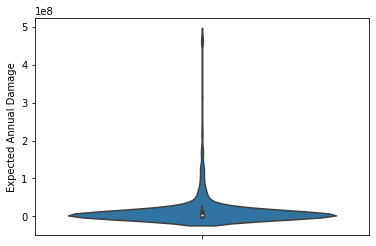

In [15]:
# Violin plot for the Expected Annual Damage

data = pd.DataFrame(outcomes)
data['policy'] = experiments['policy']
sns.violinplot(y = 'Expected Annual Damage', data=data)

plt.show()

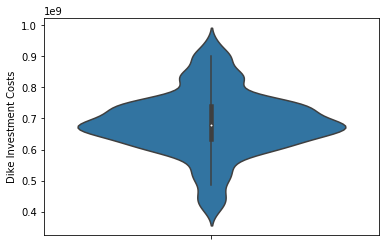

In [16]:
# Violin plot for the Dike Investment Costs

data = pd.DataFrame(outcomes)
data['policy'] = experiments['policy']
sns.violinplot(y = 'Dike Investment Costs', data=data)

plt.show()

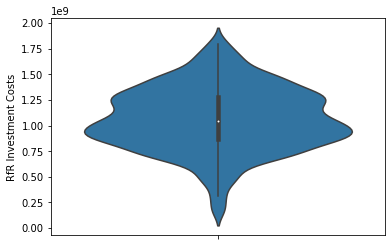

In [17]:
# Violin plot for the RfR Investment Costs

data = pd.DataFrame(outcomes)
data['policy'] = experiments['policy']
sns.violinplot(y = 'RfR Investment Costs', data=data)

plt.show()

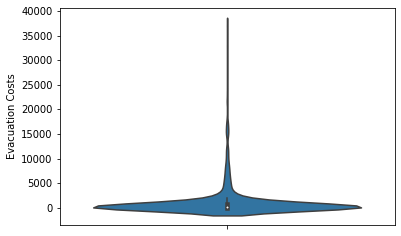

In [18]:
# Violin plot for the Evacuation Costs

data = pd.DataFrame(outcomes)
data['policy'] = experiments['policy']
sns.violinplot(y = 'Evacuation Costs', data=data)

plt.show()

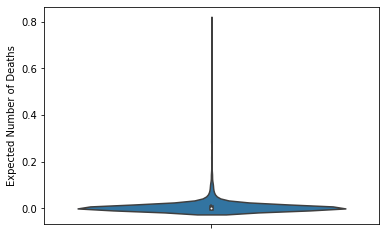

In [19]:
# Violin plot for the Evacuation Costs

data = pd.DataFrame(outcomes)
data['policy'] = experiments['policy']
sns.violinplot(y = 'Expected Number of Deaths', data=data)

plt.show()

From the violin plots we get the cut-off values, which are inserted in the robustness function

In [21]:
outcomes.keys()

dict_keys(['Expected Annual Damage', 'Dike Investment Costs', 'RfR Investment Costs', 'Evacuation Costs', 'Expected Number of Deaths'])

In [7]:
import functools

def robustness(direction, threshold, data):
    if direction == SMALLER:
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data>=threshold)/data.shape[0]

SMALLER = 'SMALLER'

Expected_Annual_Damage = functools.partial(robustness, SMALLER, 5e7) #THOSE NUMBERS NEED TO BE SPECIFIED AGAINS
Dike_Investment_Costs =  functools.partial(robustness, SMALLER, 8e8) #THOSE NUMBERS NEED TO BE SPECIFIED AGAINS
RfR_Investment_Costs =  functools.partial(robustness, SMALLER, 1.5e9) #THOSE NUMBERS NEED TO BE SPECIFIED AGAINS
Evacuation_Costs =  functools.partial(robustness, SMALLER, 5e3) #THOSE NUMBERS NEED TO BE SPECIFIED AGAINS
Expected_Number_of_Deaths = functools.partial(robustness, SMALLER, 1e-1) # Number needs to be specified



Find policies that comply to these robustness cut-off functions

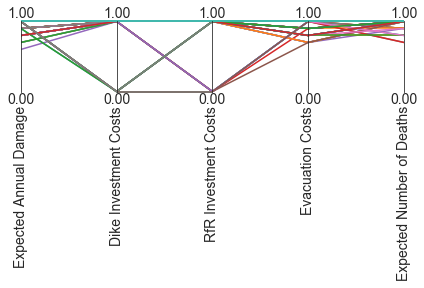

In [34]:
from ema_workbench.analysis import parcoords

experiments, outcomes = results

funcs = {'Expected Annual Damage': Expected_Annual_Damage,
         'Dike Investment Costs': Dike_Investment_Costs,
         'RfR Investment Costs': RfR_Investment_Costs,
         'Evacuation Costs': Evacuation_Costs,
         'Expected Number of Deaths': Expected_Number_of_Deaths}

total_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    logical = experiments['policy'] == policy
    
    temp_outcomes = {k:v[logical] for k,v in outcomes.items()}
    
    for k, v in temp_outcomes.items():
        score = funcs[k](v)
        scores[k] = score
    total_scores[policy] = scores

data = pd.DataFrame(total_scores).T.reset_index(drop=True)
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
limits.loc[1, :] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

In [ ]:
# If you want to change the robustness thresholds before running the optimisation 

# import functools

# def robustness(direction, threshold, data):
#     if direction == SMALLER:
#         return np.sum(data<=threshold)/data.shape[0]
#     else:
#         return np.sum(data>=threshold)/data.shape[0]

# SMALLER = 'SMALLER'

# Expected_Annual_Damage = functools.partial(robustness, SMALLER, 5e3) #THOSE NUMBERS NEED TO BE SPECIFIED AGAINS
# Dike_Investment_Costs =  functools.partial(robustness, SMALLER, 7e8) #THOSE NUMBERS NEED TO BE SPECIFIED AGAINS
# RfR_Investment_Costs =  functools.partial(robustness, SMALLER, 1e9) #THOSE NUMBERS NEED TO BE SPECIFIED AGAINS
# Evacuation_Costs =  functools.partial(robustness, SMALLER, 5e3) #THOSE NUMBERS NEED TO BE SPECIFIED AGAINS
# Expected_Number_of_Deaths = functools.partial(robustness, SMALLER, 1e-5) # Number needs to be specified

Set-up for the robust-optimization. Based on the thresholds for robustness that are specified a robustness optimization will be run

In [35]:
MAXIMIZE = ScalarOutcome.MAXIMIZE
MINIMIZE = ScalarOutcome.MINIMIZE

funcs = {'Expected Annual Damage': Expected_Annual_Damage,
         'Dike Investment Costs': Dike_Investment_Costs,
         'RfR Investment Costs': RfR_Investment_Costs,
         'Evacuation Costs': Evacuation_Costs,
         'Expected Number of Deaths':Expected_Number_of_Deaths}

# We want to minimize costs, damage and deaths

robustnes_functions = [ScalarOutcome('Fraction EA Damage', kind=MINIMIZE, 
                             variable_name='Expected Annual Damage', function=Expected_Annual_Damage),
                       ScalarOutcome('D Investment Costs', kind=MINIMIZE, 
                             variable_name='Dike Investment Costs', function=Dike_Investment_Costs),
                       ScalarOutcome('RfR Investment costs', kind=MINIMIZE,
                             variable_name='RfR Investment Costs', function=RfR_Investment_Costs),
                      ScalarOutcome('Evac Costs', kind=MINIMIZE, 
                             variable_name='Evacuation Costs', function=Evacuation_Costs),
                       ScalarOutcome('Expected Num Deaths', kind=MINIMIZE,
                             variable_name='Expected Number of Deaths', function=Expected_Number_of_Deaths)]




In [36]:
# we have to change the plausible max for total investment costs

from ema_workbench import (MultiprocessingEvaluator, ema_logging, 
                           perform_experiments, SequentialEvaluator)
from ema_workbench.em_framework.optimization import (HyperVolume, 
                                                     EpsilonProgress)
from ema_workbench.em_framework.evaluators import BaseEvaluator

convergence = [HyperVolume(minimum=[0,0,0,0,0], maximum=[1.1, 1.1, 1.1, 1.1, 3]),
              EpsilonProgress()]

epsilons=[0.05,]*len(robustnes_functions)  #final value of epsilon should be much lower.Just for experiment purposes is 1
with MultiprocessingEvaluator(dike_model) as evaluator:
    archive, convergence = evaluator.robust_optimize(robustnes_functions, scenarios, nfe=nfe,
                                                     convergence=convergence, epsilons=epsilons, population_size = 20,
                                                    convergence_freq = 20)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/1000 nfe
[MainProcess/INFO] generation 5: 98/1000 nfe
[MainProcess/INFO] generation 10: 197/1000 nfe
[MainProcess/INFO] generation 15: 293/1000 nfe
[MainProcess/INFO] generation 20: 393/1000 nfe
[MainProcess/INFO] generation 25: 489/1000 nfe
[MainProcess/INFO] generation 30: 584/1000 nfe
[MainProcess/INFO] generation 35: 683/1000 nfe
[MainProcess/INFO] generation 40: 781/1000 nfe
[MainProcess/INFO] generation 45: 879/1000 nfe
[MainProcess/INFO] generation 50: 976/1000 nfe
[MainProcess/INFO] optimization completed, found 8 solutions
[MainProcess/INFO] terminating pool


In [37]:
# Always save after running! And give it  a new title which specifies what the run was

save_results([archive, convergence], 'Robust_Optimise_1000nfe_20pop')

[MainProcess/INFO] results saved successfully to C:\Users\Samuel\Desktop\Studies\EPA\EPA1361 - Model Based Decision Making\Github Assignment Collaboration\final assignment\Robust_Optimise_1000nfe_20pop


In [10]:
# To not have to run policies all the time, they can be loaded.

from ema_workbench import load_results

archive, convergence = load_results('Robust_Optimise_1000nfe_20pop')

[MainProcess/INFO] results loaded succesfully from C:\Users\Samuel\Desktop\Studies\EPA\EPA1361 - Model Based Decision Making\Github Assignment Collaboration\final assignment\Robust_Optimise_1000nfe_20pop


In [26]:
#save_results([archive, convergence], 'Robust_Optimise_1000nfe')

[MainProcess/INFO] results saved successfully to C:\Users\Samuel\Desktop\Studies\EPA\EPA1361 - Model Based Decision Making\Github Assignment Collaboration\final assignment\Robust_Optimise_1000nfe


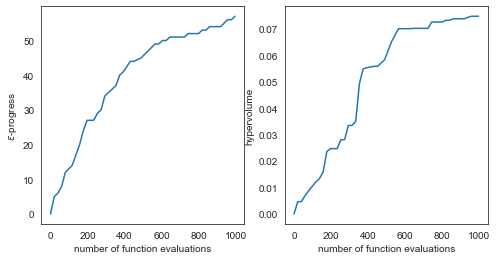

In [38]:
# Plot the epsilon progress and convergence

fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

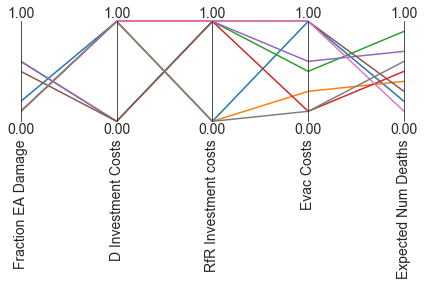

In [39]:
from ema_workbench.analysis import parcoords


data = archive.loc[:, [o.name for o in robustnes_functions]]
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
limits.loc[1, :] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

In [25]:
pd.DataFrame(outcomes)

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
0,0.0,6.445702e+08,6.984000e+08,0.0,0.0
1,0.0,6.445702e+08,6.984000e+08,0.0,0.0
2,0.0,6.445702e+08,6.984000e+08,0.0,0.0
3,0.0,6.445702e+08,6.984000e+08,0.0,0.0
4,0.0,6.445702e+08,6.984000e+08,0.0,0.0
...,...,...,...,...,...
995,0.0,7.539307e+08,1.026200e+09,0.0,0.0
996,0.0,7.539307e+08,1.026200e+09,0.0,0.0
997,0.0,7.539307e+08,1.026200e+09,0.0,0.0
998,0.0,7.539307e+08,1.026200e+09,0.0,0.0


# 1.2 Re-evaluate candidate solutions under uncertainty

In [40]:
from ema_workbench import Policy

policies = archive.drop([o.name for o in robustnes_functions], axis=1)
policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy("moro {}".format(i), **policy.to_dict()))

In [41]:
# Re-evaluate the candidate solutions under uncertainties. Perform experiments is conducted with the policies found

n_scenarios = 1000
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)

#start = time.time()
#end = time.time()

#print('Processing time:',(end-start)/60,'Minutes')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 8 policies * 1 model(s) = 8000 experiments
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 4800 cases completed
[MainProcess/INFO] 5600 cases completed
[MainProcess/INFO] 6400 cases completed
[MainProcess/INFO] 7200 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [42]:
from ema_workbench import save_results

save_results(results, 'MORO_reevaluation_PF2.tar.gz')

[MainProcess/INFO] results saved successfully to C:\Users\Samuel\Desktop\Studies\EPA\EPA1361 - Model Based Decision Making\Github Assignment Collaboration\final assignment\MORO_reevaluation_PF2.tar.gz


In [43]:
policies.to_csv('moro polices_PF2.csv')

In [8]:
# To not have to re-run the whole experiment, results can be saved and loaded

from ema_workbench import load_results

results = load_results('MORO_reevaluation_PF2.tar.gz')

[MainProcess/INFO] results loaded succesfully from C:\Users\Samuel\Desktop\Studies\EPA\EPA1361 - Model Based Decision Making\Github Assignment Collaboration\final assignment\MORO_reevaluation_PF2.tar.gz


In [23]:
# robustness_funcs is specified

robustness_funcs = {'Expected Annual Damage': Expected_Annual_Damage,
         'Dike Investment Costs': Dike_Investment_Costs,
         'RfR Investment Costs': RfR_Investment_Costs,
         'Evacuation Costs': Evacuation_Costs,
         'Expected Number of Deaths':Expected_Number_of_Deaths}

Expected_Annual_Damage = functools.partial(robustness, SMALLER, 5e7) #THOSE NUMBERS NEED TO BE SPECIFIED AGAINS
Dike_Investment_Costs =  functools.partial(robustness, SMALLER, 8e8) #THOSE NUMBERS NEED TO BE SPECIFIED AGAINS
RfR_Investment_Costs =  functools.partial(robustness, SMALLER, 1.5e9) #THOSE NUMBERS NEED TO BE SPECIFIED AGAINS
Evacuation_Costs =  functools.partial(robustness, SMALLER, 5e3) #THOSE NUMBERS NEED TO BE SPECIFIED AGAINS
Expected_Number_of_Deaths = functools.partial(robustness, SMALLER, 1e-1) # Number needs to be specified

In [24]:
# Create a dataframe of the overall robustness of the solutions based on the metrics determined in the robustness functions.
# This states how often the specific policy is within the threshold specified. 1 means always and 0 means never. Values closer to 1 are favourable.

import pandas as pd
experiments, outcomes = results

overall_robustness = {}
for policy in np.unique(experiments['policy']):
    policy_robustness = {}

    logical = experiments['policy'] == policy
    
    for outcome, values in outcomes.items():
        values = values[logical]
        policy_robustness[outcome] = robustness_funcs[outcome](values)
    overall_robustness[policy] = policy_robustness
overall_robustness = pd.DataFrame.from_dict(overall_robustness).T
overall_robustness

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
moro 0,0.218,1.0,0.0,1.000,0.197
moro 1,0.154,1.0,0.0,0.303,0.413
moro 2,0.604,0.0,1.0,0.571,0.886
moro 3,0.147,1.0,1.0,0.161,0.661
moro 4,0.595,0.0,1.0,0.697,0.730
moro 5,0.451,0.0,1.0,1.000,0.368
moro 6,0.161,1.0,1.0,1.000,0.140
moro 7,0.154,1.0,0.0,0.168,0.721


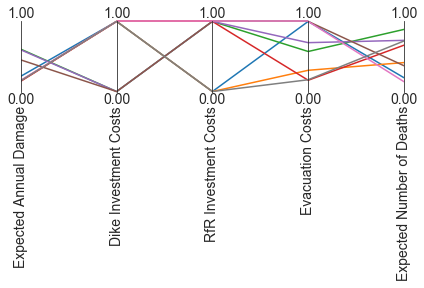

In [25]:
# Visualise the outcomes of the robust optimisation with regards to the different metrics 

from ema_workbench.analysis import parcoords

data = overall_robustness.loc[:, ['Expected Annual Damage','Dike Investment Costs','RfR Investment Costs','Evacuation Costs', 'Expected Number of Deaths']]
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
limits.loc[1, :] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

In [27]:
outcomes

{'Expected Annual Damage': array([2.32309647e+08, 2.97003962e+08, 3.58856850e+08, ...,
        3.91538010e+08, 3.42249178e+08, 3.84390907e+07]),
 'Dike Investment Costs': array([3.00950120e+08, 3.00950120e+08, 3.00950120e+08, ...,
        4.79354712e+08, 4.79354712e+08, 4.79354712e+08]),
 'RfR Investment Costs': array([1.5063e+09, 1.5063e+09, 1.5063e+09, ..., 1.5063e+09, 1.5063e+09,
        1.5063e+09]),
 'Evacuation Costs': array([    0.        ,     0.        ,     0.        , ...,
        39803.725079  , 33949.46249603,  4343.27829466]),
 'Expected Number of Deaths': array([0.65340904, 0.53235183, 1.09183614, ..., 0.1917793 , 0.11583482,
        0.01266141])}

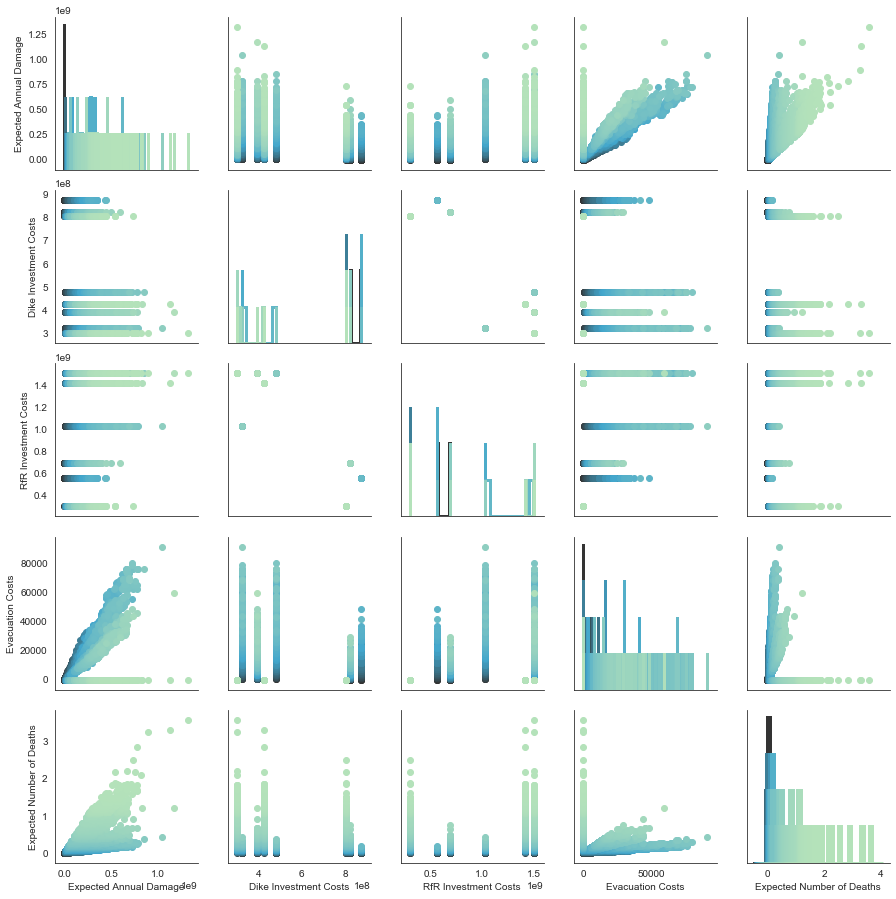

In [28]:
# The outcomes will be visualised. Here they are visualised based on the Expected Number of Deaths
# This takes about 10-15 mins to run

import seaborn as sns

g2 = sns.PairGrid(pd.DataFrame(outcomes), hue="Expected Number of Deaths", palette="GnBu_d")
g2 = g2.map_diag(plt.hist, histtype="step", linewidth=3)
g2 = g2.map_offdiag(plt.scatter)

In [29]:
# Create a dataframe with both the experimetns and outcomes, this allows the pair plot to be made based on the policy

dataframe = pd.concat([experiments, pd.DataFrame(outcomes)], axis = 1)
dataframe

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
0,84.0,221.907370,1.5,0.435028,242.196909,1.0,0.447800,279.725851,1.0,0.239240,...,0.0,1.0,630,moro 0,dikesnet,2.323096e+08,3.009501e+08,1.506300e+09,0.000000,0.653409
1,53.0,133.634245,1.0,0.986484,72.798815,1.0,0.091034,31.874633,10.0,0.680244,...,0.0,1.0,631,moro 0,dikesnet,2.970040e+08,3.009501e+08,1.506300e+09,0.000000,0.532352
2,100.0,45.706028,1.0,0.352367,63.329092,10.0,0.699699,315.128714,10.0,0.033845,...,0.0,1.0,632,moro 0,dikesnet,3.588568e+08,3.009501e+08,1.506300e+09,0.000000,1.091836
3,116.0,81.784511,1.0,0.799725,277.215003,1.5,0.683652,87.038039,1.5,0.783713,...,0.0,1.0,633,moro 0,dikesnet,1.091313e+07,3.009501e+08,1.506300e+09,0.000000,0.029500
4,121.0,295.852774,1.0,0.054667,206.929513,10.0,0.152427,122.507325,10.0,0.273921,...,0.0,1.0,634,moro 0,dikesnet,2.239513e+08,3.009501e+08,1.506300e+09,0.000000,0.445628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,57.0,36.033292,10.0,0.013144,288.323630,1.5,0.336408,192.937043,10.0,0.373807,...,0.0,1.0,1625,moro 7,dikesnet,5.687769e+07,4.793547e+08,1.506300e+09,5544.162121,0.024862
7996,22.0,92.171136,1.0,0.552011,37.783470,1.0,0.624001,307.214840,10.0,0.916190,...,0.0,1.0,1626,moro 7,dikesnet,6.631360e+07,4.793547e+08,1.506300e+09,6420.168042,0.018774
7997,119.0,50.340206,10.0,0.668898,214.747142,10.0,0.126872,90.525871,1.5,0.085512,...,0.0,1.0,1627,moro 7,dikesnet,3.915380e+08,4.793547e+08,1.506300e+09,39803.725079,0.191779
7998,82.0,139.479266,10.0,0.510252,150.559747,10.0,0.270765,343.879317,1.5,0.291765,...,0.0,1.0,1628,moro 7,dikesnet,3.422492e+08,4.793547e+08,1.506300e+09,33949.462496,0.115835


E:\Anaconda\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
E:\Anaconda\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


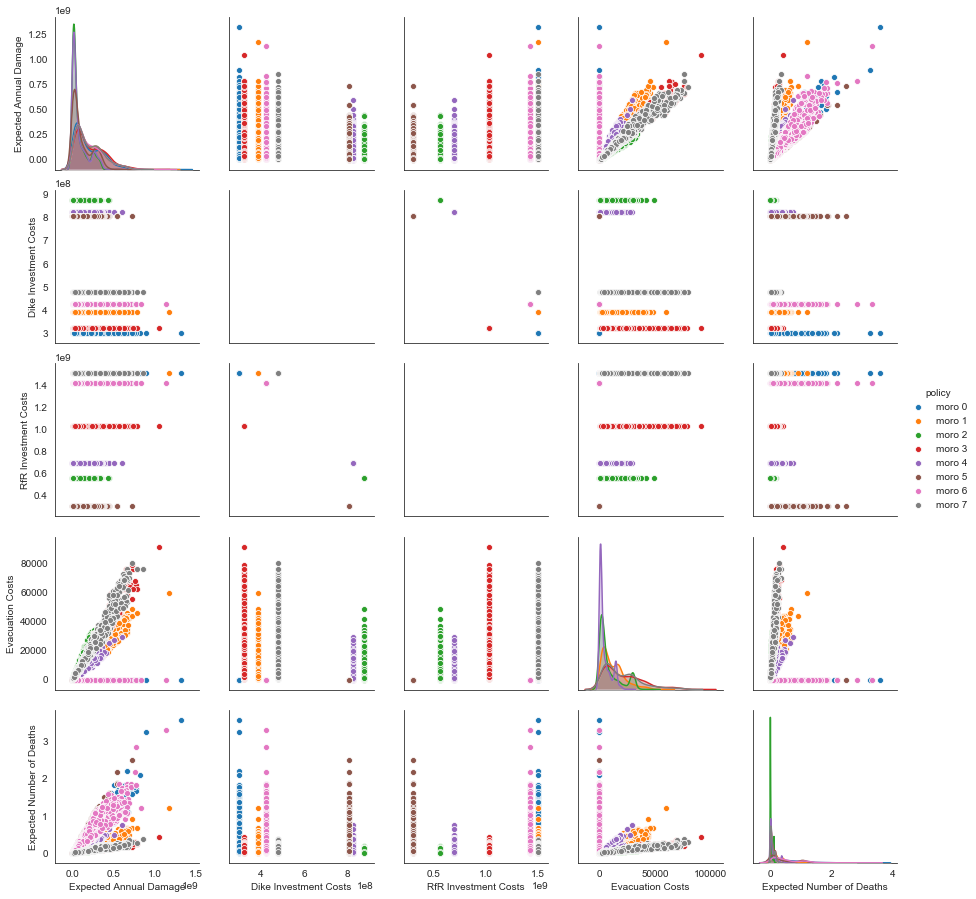

In [31]:
# Plot a pairplot based on the policy (hue)

sns.pairplot(dataframe[['Expected Annual Damage', 'Dike Investment Costs', 'RfR Investment Costs','Evacuation Costs','Expected Number of Deaths', 'policy']], hue = "policy")